In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from owlrl import DeductiveClosure, OWLRL_Semantics
from rdflib import *
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
from pyshacl import validate

def plot_graph(graph, axes=None, show=True):
    ax = axes or plt.gca()
    netgraph = rdflib_to_networkx_multidigraph(graph)
    for layer, nodes in enumerate(nx.topological_generations(netgraph)):
        for node in nodes:
            netgraph.nodes[node]["layer"] = layer
    pos = nx.multipartite_layout(netgraph, subset_key="layer")
    edge_labels = nx.get_edge_attributes(netgraph, 'r')
    nx.draw_networkx(netgraph, pos=pos, with_labels=True, ax=ax)
    nx.draw_networkx_edge_labels(netgraph, pos=pos, edge_labels=edge_labels, ax=ax)
    if show:
        plt.show()

In [2]:
ontology = Graph()
ontology.parse(r'../ontologies/ontology_full.ttl')
ontology.parse(r'../ontologies/BIGOWLData.owl')
ontology.parse(r'../ontologies/BIGOWLProblems.owl')
ontology.parse(r'../ontologies/BIGOWLAlgorithms.owl')
ontology.parse(r'../ontologies/BIGOWLWorkflows.owl')
ontology.parse(r'../dataset_annotator/penguins_annotated.ttl')
ontology.parse(r'../dataset_annotator/titanic_annotated.ttl')
ontology.parse(r'../ontology_populator/restrictions.ttl')
ontology.parse(r'../ontology_populator/components.ttl')
DeductiveClosure(OWLRL_Semantics).expand(ontology)

bigowl_data = Namespace('https://w3id.org/BIGOWLData/')
bigowl_algorithms = Namespace('https://w3id.org/BIGOWLAlgorithms/')
bigowl_problems = Namespace('https://w3id.org/BIGOWLProblems/')
bigowl_workflows = Namespace('https://w3id.org/BIGOWLWorkflows/')
do = Namespace('https://diviloper.dev/ontology#')
abox = Namespace('https://diviloper.dev/ABox#')
dmop = Namespace('http://www.e-lico.eu/ontologies/dmo/DMOP/DMOP.owl#')

In [3]:
ug = Graph()
ug.add((abox.ClusteringIntent1, RDF.type, do.UserIntent))
ug.add((abox.ClusteringIntent1, do.tacklesProblem, do.Clustering))
ug.add((abox.ClusteringIntent1, do.overData, abox.term('penguins.csv')))

ug2 = Graph()
ug2.add((abox.ClusteringIntent2, RDF.type, do.UserIntent))
ug2.add((abox.ClusteringIntent2, do.tacklesProblem, do.Describe))
ug2.add((abox.ClusteringIntent2, do.overData, abox.term('penguins.csv')))
parameter_value = BNode()
ug2.add((abox.ClusteringIntent2, do.specifiesParameterValue, parameter_value))
ug2.add((parameter_value, do.forParameterName, Literal('Number of Clusters')))
ug2.add((parameter_value, do.withValue, Literal(3, datatype=XSD.integer)))

ug3 = Graph()
ug3.add((abox.ClusteringIntent3, RDF.type, do.UserIntent))
ug3.add((abox.ClusteringIntent3, do.tacklesProblem, do.Describe))
ug3.add((abox.ClusteringIntent3, do.overData, abox.term('penguins.csv')))
parameter_value = BNode()
ug3.add((abox.ClusteringIntent3, do.specifiesParameterValue, parameter_value))
ug3.add((parameter_value, do.forParameterName, Literal('epsilon')))
ug3.add((parameter_value, do.withValue, Literal(0.7)))

<Graph identifier=Nf0d5ea005c22479db1f965443cd54c4d (<class 'rdflib.graph.Graph'>)>

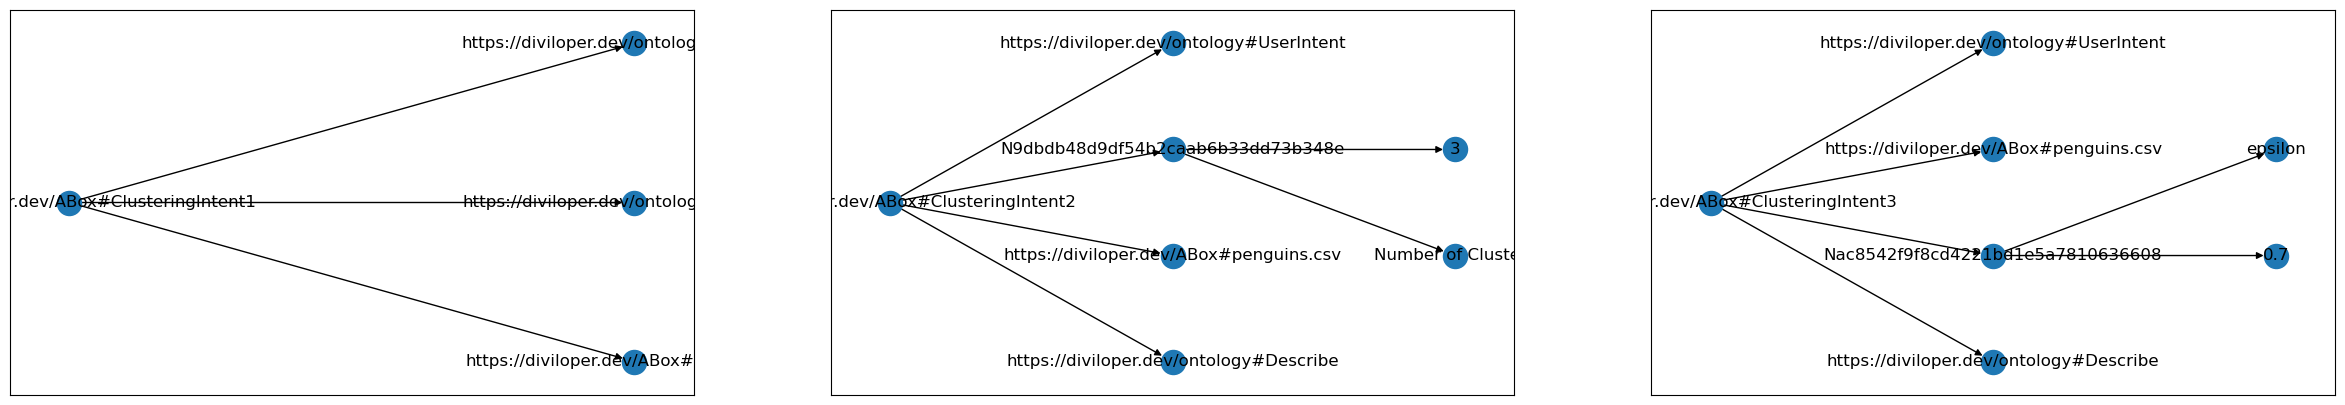

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(30, 5))
plot_graph(ug, axes=axs[0], show=False)
plot_graph(ug2, axes=axs[1], show=False)
plot_graph(ug3, axes=axs[2], show=False)
plt.show()

In [5]:
# Input: graph + user intent iri
intent = ug
user_intent = abox.ClusteringIntent1
workflow_name = 'Clustering1'

In [6]:
def get_intent_dataset_problem(intent_graph, intent_iri):
    result = intent_graph.query(f"""
    PREFIX do: <{do}>
    SELECT ?dataset ?problem
    WHERE {{
        <{intent_iri}> a do:UserIntent .
        <{intent_iri}> do:overData ?dataset .
        <{intent_iri}> do:tacklesProblem ?problem .
    }}
""").bindings[0]
    return result['dataset'], result['problem']

In [7]:
def get_intent_params(intent_graph, intent_iri):
    result = intent_graph.query(f"""
    PREFIX do: <{do}>
    SELECT ?param_name ?value
    WHERE {{
        <{intent_iri}> a do:UserIntent .
        <{intent_iri}> do:specifiesParameterValue ?param_value .
        ?param_value do:forParameterName ?param_name .
        ?param_value do:withValue ?value .
    }}
""").bindings
    return result

In [8]:
def get_loaders(ontology_graph, dataset_iri):
    result = ontology_graph.query(f"""
    PREFIX do: <{do}>
    PREFIX big_w: <{bigowl_workflows}>
    PREFIX big_d: <{bigowl_data}>
    SELECT ?loader ?path
    WHERE {{
        <{dataset_iri}> do:fileFormat ?format ;
                    big_d:path ?path .
        ?loader a big_w:DataIngestion ;
                do:fileFormat ?format .
    }}
""").bindings
    return result

In [9]:
def get_components(ontology_graph, problem_iri, intent_parameters):
    intent_params_match = [f'            big_w:hasParameter ?param_{i} ;' for i in range(len(intent_parameters))]
    intent_params_filters = [f"""
        FILTER regex(?parameterLabel, "{param['param_name']}", "i")
        {{
            ?param_{i} rdfs:label ?parameterLabel .
        }} UNION {{
            ?param_{i} big_w:hasName ?parameterLabel .
        }}""" for i, param in enumerate(intent_parameters)]

    result = ontology_graph.query(f"""
    PREFIX do: <{do}>
    PREFIX big_w: <{bigowl_workflows}>
    PREFIX big_p: <{bigowl_problems}>
    PREFIX big_a: <{bigowl_algorithms}>
    SELECT ?component
    WHERE {{
        ?component a big_w:Component ;
{''.join(intent_params_match)}
            big_w:hasAlgorithm ?algorithm .
        ?algorithm big_a:solves ?p .
        ?p do:subProblemOf* <{problem_iri}> .
{''.join(intent_params_filters)}
    }}
""").bindings

    return result

In [20]:
def get_component_input_shapes(ontology_graph, component):
    results = ontology_graph.query(f"""
        PREFIX big_w: <{bigowl_workflows}>
        PREFIX sh: <{SH}>
        SELECT ?shape
        WHERE {{
            <{component}> big_w:specifiesInputClass ?shape .
            ?shape a sh:NodeShape .
        }}
    """).bindings
    shape = results[0]['shape']
    return flatten_shape(ontology_graph, shape)

def flatten_shape(graph, shape):
    if (shape, SH['and'], None) in graph:
        subshapes = graph.query(f"""
            PREFIX sh: <{SH}>
            SELECT ?shape
            WHERE {{
                <{shape}> sh:and ?andNode .
                ?andNode rdf:rest*/rdf:first/sh:node ?shape .
            }}
        """).bindings

        return [x for subshape in subshapes for x in flatten_shape(graph, subshape['shape'])]
    else:
        return [shape]


def find_component_to_satisfy_shape(ontology_graph, shape):
    result = ontology_graph.query(f"""
        PREFIX big_w: <{bigowl_workflows}>
        PREFIX sh: <{SH}>
        SELECT ?component
        WHERE {{
            ?component big_w:specifiesOutputClass <{shape}> .
        }}
    """).bindings
    return [x['component'] for x in result]

In [11]:
def get_component_params(ontology_graph, components, intent_parameters):
    param_query = f"""
    PREFIX big_w: <{bigowl_workflows}>
    SELECT ?param ?param_name ?value
    WHERE {{
        <%s> big_w:hasParameter ?param .
        ?param big_w:hasName ?param_name .
        OPTIONAL {{
            ?param big_w:hasDefaultValue ?value .
        }}
    }}"""
    result = [
        [{str(k): v for k, v in x.items()} for x in ontology_graph.query(param_query % component['component']).bindings]
        for component in components]

    for intent_param in intent_parameters:
        for param in result:
            for p in param:
                if p['param_name'].lower() == intent_param['param_name'].lower():
                    p['value'] = intent_param['value']

    return result

In [12]:
def add_task(graph, pipeline, task_name, component, parameters, order, previous_task=None, inputs=None, outputs=None):
    if outputs is None:
        outputs = []
    if inputs is None:
        inputs = []
    task = abox.term(task_name)
    graph.add((pipeline, bigowl_workflows.hasTask, task))
    graph.add((task, RDF.type, bigowl_workflows.Task))
    graph.add((task, bigowl_workflows.hasComponent, component))
    graph.add((task, bigowl_workflows.order, Literal(order)))
    for input in inputs:
        graph.add((task, bigowl_workflows.hasInput, input))
    for output in outputs:
        graph.add((task, bigowl_workflows.hasOutput, output))
    for param in parameters:
        param_value = BNode()
        graph.add((task, do.hasParameterValue, param_value))
        graph.add((param_value, do.forParameter, param['param']))
        if 'value' in param:
            graph.add((param_value, do.hasValue, param['value']))
        else:
            graph.add((param_value, do.hasValue, Literal('REQUIRES USER INPUT')))
    if previous_task:
        graph.add((previous_task, bigowl_workflows.connectedTo, task))
    return task

In [13]:
def satisfies_shape(data_graph, shacl_graph, shape, focus):
    conforms, _, _ = validate(data_graph, shacl_graph=shacl_graph, validate_shapes=[shape], focus=focus)
    return conforms


def get_shape_target_class(ontology, shape):
    return ontology.query(f"""
        PREFIX sh: <{SH}>
        SELECT ?targetClass
        WHERE {{
            <{shape}> sh:targetClass ?targetClass .
        }}
    """).bindings[0]['targetClass']

## Algorithm

In [43]:
dataset, problem = get_intent_dataset_problem(intent, user_intent)

intent_params = get_intent_params(intent, user_intent)

loaders = get_loaders(ontology, dataset)
dataset_loader = loaders[0]

components = get_components(ontology, problem, intent_params)[2:]

params = get_component_params(ontology, components, intent_params)

workflow_graphs = [Graph() for _ in range(len(components))]
for i, workflow_graph in enumerate(workflow_graphs):
    task_order = 1
    wf_name = f'wf/{workflow_name}/{i}'
    workflow = abox.term(wf_name)
    workflow_graph.add((workflow, RDF.type, bigowl_workflows.Workflow))

    load_task = add_task(workflow_graph, workflow, f'{wf_name}/{task_order}', dataset_loader['loader'],
                         [{'param': do.URL_Param, 'value': dataset_loader['path']}], task_order, outputs=[dataset])
    task_order += 1
    main_component = components[i]['component']
    shapes_to_satisfy = get_component_input_shapes(ontology, main_component)
    unsatisfied_shapes = [shape for shape in shapes_to_satisfy if not satisfies_shape(ontology, ontology, shape, dataset)]


    previous_output = dataset
    previous_task = load_task
    for j, shape in enumerate(unsatisfied_shapes):
        component_to_satisfy_shape = find_component_to_satisfy_shape(ontology, shape)
        if len(component_to_satisfy_shape) == 0:
            raise Exception(f'No component found to satisfy shape {shape}')
        new_output = BNode()

        mid_task = add_task(workflow_graph, workflow, f'{wf_name}/{task_order}', component_to_satisfy_shape[0], [], task_order,
                                  previous_task, inputs=[previous_output], outputs=[new_output])
        task_order += 1

        workflow_graph.add((new_output, RDF.type, get_shape_target_class(ontology, shape)))
        workflow_graph.add((new_output, do.conformsTo, shape))

        for (s, p, o) in workflow_graph.triples((previous_output, do.conformsTo, None)):
            workflow_graph.add((new_output, p, o))

        previous_output = new_output
        previous_task = mid_task

    component_task = add_task(workflow_graph, workflow, f'{wf_name}/{task_order}', components[i]['component'], params[i], task_order,
                              previous_task, inputs=[previous_output])

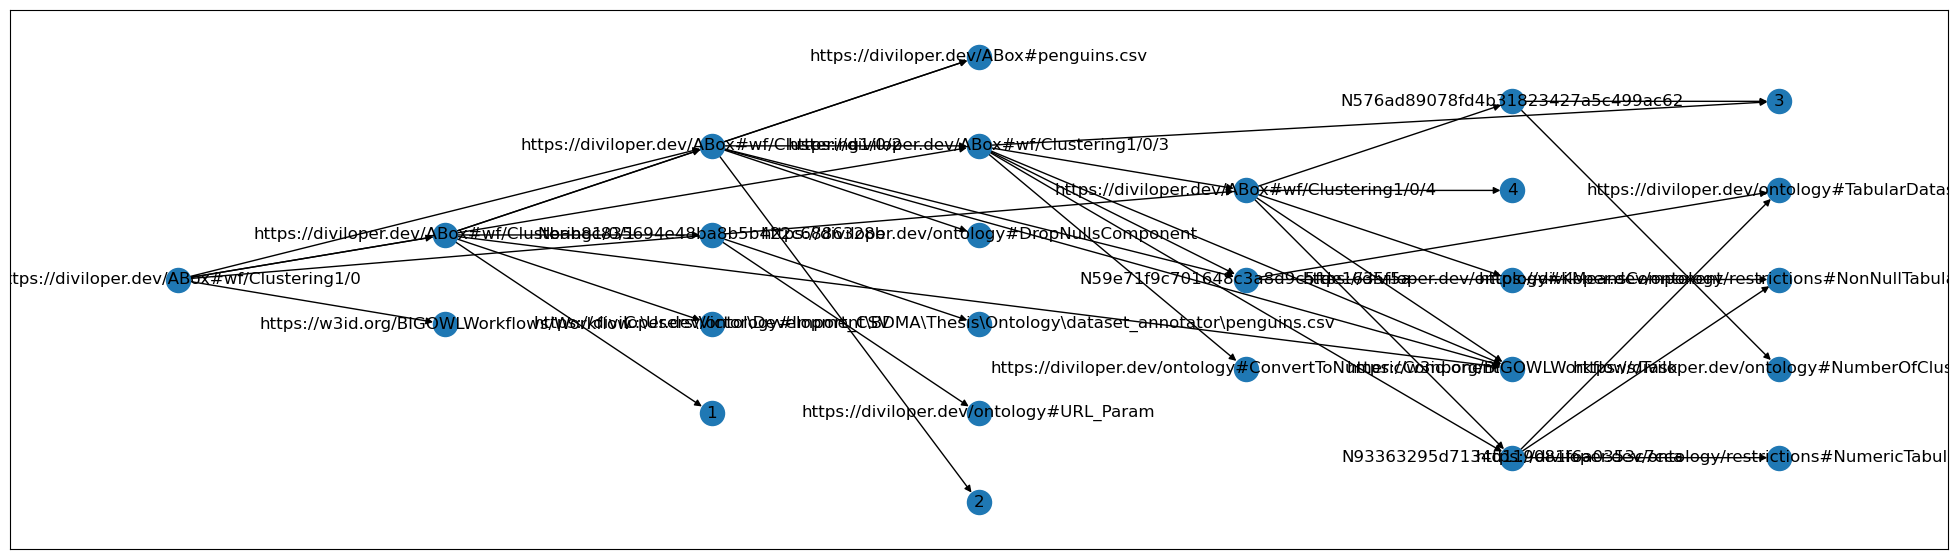

In [44]:
for wf in workflow_graphs:
    plt.figure(figsize=(25, 7))
    plot_graph(wf)

In [45]:
for i, workflow_graph in enumerate(workflow_graphs):
    workflow_graph.serialize(f'./{workflow_name}_{i}.ttl')
intent.serialize(f'./{workflow_name}_user_intent.ttl')

<Graph identifier=Nf176c490cb9342d0a509558ef741f588 (<class 'rdflib.graph.Graph'>)>